# About

scatch to build the final notebook

this version uses GloVe for pre-trained embeddings

In [263]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statistics
import janitor

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.models import Sequential
from keras.models import Model
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Embedding
from keras.layers import Dense, Input, GlobalMaxPooling1D
from keras.layers import Conv1D, MaxPooling1D, Embedding
from keras.initializers import Constant

In [407]:
def prep_interim_data(p_ca_pos, p_out):
    '''
    helper function to prepare the interim dataset
    intention is to mimic the catalog data at the Employer
    we don't need much of the data, just the unspsc codes and the item names
    
    params
        p_ca_pos
            path to the data file, i.e.
            ~/data/external/ca-po/PURCHASE_ORDER_DATA_EXTRACT_2012-2015_CLEANED.zip
        
        p_unspsc_items
            path to the iterim data file, i.e.
            ~/data/interim/unspsc-item.csv
            
    '''
    t1 = pd.read_csv(p_ca_pos, dtype=str).clean_names()
    t2 = t1[["normalized_unspsc", "item_name"]]
    t3 = t2.drop_duplicates().dropna()
    t4 = t3.sort_values(by=["normalized_unspsc", "item_name"]).reset_index(drop = True)
    t4.to_csv(p_out, index = False)
    print("interim data saved to ", p_unspsc_items)
    
def sample_unspsc_item(unspsc_items, n_unspsc, n_per_unspsc, min_per_unspsc, max_per_unspsc, random_state = 0):
    '''
    helper function to sample n_per_unspsc number of examples per unspsc code,
    and n_unspsc number of codes overall
    
    params
        unspsc_items
            the data frame that contains the unspsc_items
            
        n_unspsc
            the number of unspsc codes we want to use in our run
        
        n_per_unspsc
            the number of items we want per unspsc code
            should be between min_per_unspsc and max_per_unspsc
        
        min_per_unspsc
            the min number of items we want per class 
            
        max_per_unspsc
            the max number of items we want per class
        
        random_state
            to set random seed, default 0
    '''
    # gets count of items per unspsc code, 
    # and filters for codes that have number of items between the min and max
    t1 = unspsc_items.groupby("normalized_unspsc").count().reset_index()
    t2 = t1.item_name.between(min_per_unspsc, max_per_unspsc, inclusive = True)
    t3 = t1[t2]
    relevant = t3
    
    # gets list of unique unspsc codes,
    # and randomly picks n_unspsc number of them for use
    t1 = relevant[["normalized_unspsc"]]
    t2 = t1.drop_duplicates()
    t3 = t2.sample(n = n_unspsc, random_state = random_state).normalized_unspsc
    uc = t3
    
    # gets only the items for the randomly picked unspsc codes
    filtered = unspsc_items[unspsc_items["normalized_unspsc"].isin(uc)]
    
    # gets a sample of items from each randomly picked unspsc code
    t1 = filtered.groupby("normalized_unspsc")
    t2 = t1.apply(lambda x: x.sample(n = n_per_unspsc, replace = False, random_state = random_state))
    t3 = t2.reset_index(drop  = True).sort_values(by = ["normalized_unspsc", "item_name"]).reset_index(drop  = True)
    t4 = t3.drop_duplicates()
    results = t4
    return(results)

def get_embeddings(p_glove):
    '''
    helper function to load GloVe embeddings
    see https://github.com/keras-team/keras/blob/master/examples/pretrained_word_embeddings.py
    
    params
        p_glove
            path to the GloVe embeddings, i.e.
            ~/data/external/glove/glove.6B.100d.txt
    '''
    embeddings_index = {}
    with open(p_glove) as f:
        for line in f:
            word, coefs = line.split(maxsplit=1)
            coefs = np.fromstring(coefs, 'f', sep=' ')
            embeddings_index[word] = coefs

    return(embeddings_index)

def prep_text_and_labels(unspsc_item):
    '''
    helper function to convert unspsc_item_samples into format usable for training
    see https://github.com/keras-team/keras/blob/master/examples/pretrained_word_embeddings.py
    
    params
        unspsc_item
            dataframe of unspsc_item, or some sample of unspsc_item
    '''
    texts = []  # list of text samples
    labels_index = {}  # dictionary mapping label name to numeric id
    labels = []  # list of label ids
    
    texts = unspsc_item.item_name.tolist()
    label_id = 0
    for x in unspsc_item.normalized_unspsc:
        if x in labels_index.keys():
            pass
        else:
            label_id = len(labels_index)
        labels_index[x] = label_id
        labels.append(label_id)
    return(texts, labels_index, labels)

def vectorize_texts(texts, labels, n_max_words, n_padding):
    '''
    helper function to vectorize the text samples into a 2D integer tensor
    see https://github.com/keras-team/keras/blob/master/examples/pretrained_word_embeddings.py
    
    params
        texts
            list of texts
        
        labels
            list of class labels
    '''
    tokenizer = Tokenizer(num_words = n_max_words)
    tokenizer.fit_on_texts(texts)
    sequences = tokenizer.texts_to_sequences(texts)

    word_index = tokenizer.word_index
    print('Found %s unique tokens.' % len(word_index))

    data = pad_sequences(sequences, maxlen = n_padding, padding = "post")

    labels_oh = to_categorical(np.asarray(labels))
    print('Shape of data tensor:', data.shape)
    print('Shape of label tensor:', labels_oh.shape)
    
    return(data, labels_oh, word_index)

def prep_embedding_matrix(word_index, embeddings_index, n_max_words, embed_dim):
    '''
    helper function to prepare the embedding matrix
    basically looks up the word in the embeddings index created earlier from GloVe
    see https://github.com/keras-team/keras/blob/master/examples/pretrained_word_embeddings.py
    
    params
        word_index
        embeddings_index
        n_max_words
        embed_dim
    '''
    num_words = min(n_max_words, len(word_index) + 1)
    embedding_matrix = np.zeros((num_words, embed_dim))
    for word, i in word_index.items():
        if i >= n_max_words:
            # ignores words that are more than the max number of words allowed
            continue
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            # words not found in embedding index will be all-zeros.
            embedding_matrix[i] = embedding_vector
            
    return(embedding_matrix)

def split_data(data, labels, labels_oh, split, random_state = 0):
    '''
    split the data into a training set and a validation set
    note for this to simulate catalog data, we need stratified split, per class
    
    params
        data
        labels
        labels_oh
        split
    '''
    np.random.seed(random_state)
    x_train = np.empty((0, data[0].shape[0]))
    y_train = np.empty((0, labels_oh[0].shape[0]))
    x_val = np.empty((0, data[0].shape[0]))
    y_val = np.empty((0, labels_oh[0].shape[0]))
    
    # gets unique classes
    uc = np.unique(labels)
    
    # for each class, 
    # subsets the data and labels_oh, 
    # and assigns some to train, some to validation 
    # this makes sure each class has some representation in train, and some in validation
    for c in uc:
        t1 = (labels == c)
        data_c = data[t1]
        labels_oh_c = labels_oh[t1]
        indices = np.arange(data_c.shape[0])
        np.random.shuffle(indices)
        data_c = data_c[indices]
        labels_oh_c = labels_oh_c[indices]
        num_validation_samples = int(split * data_c.shape[0])
        x_train_c = data_c[:-num_validation_samples]
        y_train_c = labels_oh_c[:-num_validation_samples]
        x_val_c = data_c[-num_validation_samples:]
        y_val_c = labels_oh_c[-num_validation_samples:]
        
        x_train = np.concatenate([x_train, x_train_c])
        y_train = np.concatenate([y_train, y_train_c])
        x_val = np.concatenate([x_val, x_val_c])
        y_val = np.concatenate([y_val, y_val_c])
    
    return(x_train, y_train, x_val, y_val)



In [420]:
# paths to data
p_ca_pos = os.path.join("..", "data", "external", "ca-po", "PURCHASE_ORDER_DATA_EXTRACT_2012-2015_CLEANED.zip")
p_unspsc_items = os.path.join("..", "data", "interim", "unspsc-item.csv")
p_glove = os.path.join("..", "data", "external", "glove", "glove.6B.100d.txt")

# some global params
NUM_CLASSES = 10 # number of classes we want to try for in this run
NUM_EXAMPLES_PER_CLASS = 2 # number of instances we want per class, to simulate catalog data, should be between min and max
MIN_EXAMPLES_PER_CLASS = 2 # for picking good examples, should be greater than 1
MAX_EXAMPLES_PER_CLASS = 99999 # for picking good examples, should be greater than MIN_EXAMPLES_PER_CLASS

MAX_NUM_WORDS = 2000 # for vocab size
MAX_SEQUENCE_LENGTH = 1000 # for padding
VALIDATION_SPLIT = 0.5 # for train vs validation set size (this is per class split)
EMBEDDING_DIM = 100 # i.e. how wide to make the embedding. Since we are using GloVe, keep at 100

# Introduction

Inspired by problem from work. Global procurement system. Every item needs to be categorized for catalog. Item to a code. By nature of a catalog, very few items belong in each code "bucket". And there are lots of items and lots of codes, so looking for a better way to categorize items.

We don't have access to the real data from work. Instead we start with the California PO data. As part of POs, there are items and unspsc codes, which can stand in for the catalog data from work. We will need to massage the data a bit to make it resemble work data.

In [204]:
# gets and preps interim data
# We don't need all the PO data, so just stripping it down to item and unspsc codes
prep_interim_data(p_ca_pos, p_unspsc_items)

interim data saved to  ../data/interim/unspsc-item.csv


In [205]:
# gets interim data
unspsc_items = pd.read_csv(p_unspsc_items, dtype=str).clean_names()

In [206]:
unspsc_items.head()

,normalized_unspsc,item_name
0,10101501,iphone
1,10101502,Amendment 1 - Option to Renew
2,10101502,"CANINE, LAW ENFORCEMENT, NON-BITE, SEARCH DOG"
3,10101502,CANINES
4,10101502,"CANINES, NON-BITE"


In [207]:
unspsc_items.shape

(215140, 2)

In [208]:
unspsc_items.describe()

,normalized_unspsc,item_name
count,215140,215140
unique,13405,178890
top,44103103,Medical Supplies
freq,2717,769


we want to get a sample of the unspsc codes and items

even if unbalanced, to mimic catalogs, we would want only a couple of items per unspsc code

Note most unspsc codes only have a few items, which is quite similar to the real data that we don't have access to. Average items per code is 3. To make the California data reflect the real data, we need to constrain our data so that we only have a few items per unspsc code. But for the train-validate split to work, we need at least two items per code.

median items per unspsc code 3


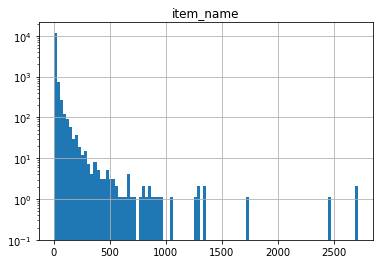

In [266]:
t1 = unspsc_items.groupby("normalized_unspsc").count()
t2 = t1.item_name.tolist()
print("median items per unspsc code", statistics.median(t2))

fig, ax = plt.subplots()
t1.hist(ax=ax, bins=100, bottom=0.1)
ax.set_yscale("log")

In [424]:
# preps samples
unspsc_item_samples = sample_unspsc_item(
    unspsc_items, 
    n_unspsc = NUM_CLASSES, 
    n_per_unspsc = NUM_EXAMPLES_PER_CLASS,
    min_per_unspsc = MIN_EXAMPLES_PER_CLASS,
    max_per_unspsc = MAX_EXAMPLES_PER_CLASS, 
    random_state = 0)

In [426]:
unspsc_item_samples.shape

(20, 2)

In [425]:
unspsc_item_samples.head(10)

,normalized_unspsc,item_name
0,11162111,Mech Assy Pass Side
1,11162111,mesh door guard
2,14122103,"CLIN #15, ROLLSTOCK"
3,14122103,ROLL STOCK
4,25101502,GLAVAL BUS CUT AWAY CHASSIS E-450 GAS BUS
5,25101502,Inmate Security Bus
6,30161602,"C12E0037, Agreement"
7,30161602,PANELS
8,41113720,fiber optic equipment
9,41113720,traffic equipment


In [412]:
unspsc_item_samples.describe()

,normalized_unspsc,item_name
count,50,50
unique,10,50
top,52161514,"1 OZ PLASTIC SOUFFLE CUPS,"
freq,5,1


Prep text and labels

In [427]:
texts, labels_index, labels = prep_text_and_labels(unspsc_item_samples)

In [428]:
print(len(texts))
print(texts)
print(labels_index)
print(labels)

20
['Mech Assy Pass Side', 'mesh door guard', 'CLIN #15, ROLLSTOCK', 'ROLL STOCK', 'GLAVAL BUS CUT AWAY CHASSIS E-450 GAS BUS', 'Inmate Security Bus', 'C12E0037, Agreement', 'PANELS', 'fiber optic equipment', 'traffic equipment', 'CLAS ON LINE CAPABILITIES -', 'Workforce Scheduler', 'BENCHORGANIZER,L-SHAPE,ESD-SAFE', 'Monthly planer refill for 2014', 'CSP-SQ ORDER', 'csp-sq order', 'EEI Curriculum', 'Laboratory Supplies', 'Pager Service (MH 3of3)', 'Pager Service (Medical 2of2) (CIW)']
{'11162111': 0, '14122103': 1, '25101502': 2, '30161602': 3, '41113720': 4, '43231605': 5, '44111516': 6, '50303501': 7, '60106207': 8, '81161705': 9}
[0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]


In [429]:
# note, the labels gets converted to a one-hot class matrix, 
# so that we later we can calculate cross-entropy loss against it
data, labels_oh, word_index = vectorize_texts(texts, labels, MAX_NUM_WORDS, MAX_SEQUENCE_LENGTH)

Found 59 unique tokens.
Shape of data tensor: (20, 1000)
Shape of label tensor: (20, 10)


In [430]:
print(data[0:10])
print(labels_oh[0:10])
print(word_index)

[[ 8  9 10 ...  0  0  0]
 [12 13 14 ...  0  0  0]
 [15 16 17 ...  0  0  0]
 ...
 [31  0  0 ...  0  0  0]
 [32 33  2 ...  0  0  0]
 [34  2  0 ...  0  0  0]]
[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]
{'bus': 1, 'equipment': 2, 'csp': 3, 'sq': 4, 'order': 5, 'pager': 6, 'service': 7, 'mech': 8, 'assy': 9, 'pass': 10, 'side': 11, 'mesh': 12, 'door': 13, 'guard': 14, 'clin': 15, '15': 16, 'rollstock': 17, 'roll': 18, 'stock': 19, 'glaval': 20, 'cut': 21, 'away': 22, 'chassis': 23, 'e': 24, '450': 25, 'gas': 26, 'inmate': 27, 'security': 28, 'c12e0037': 29, 'agreement': 30, 'panels': 31, 'fiber': 32, 'optic': 33, 'traffic': 34, 'clas': 35, 'on': 36, 'line': 37, 'capabilities': 38, 'workforce': 39, 'scheduler

split into train and validation sets

In [431]:
x_train, y_train, x_val, y_val = split_data(data, labels, labels_oh, VALIDATION_SPLIT)

In [434]:
print(x_train.shape)
print(y_train.shape)
print(x_val.shape)
print(y_val.shape)

(10, 1000)
(10, 10)
(10, 1000)
(10, 10)


Preparing embeddings

In [435]:
# get embeddings
embeddings_index = get_embeddings(p_glove)
print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [436]:
embedding_matrix = prep_embedding_matrix(word_index, embeddings_index, MAX_NUM_WORDS, EMBEDDING_DIM)
print(embedding_matrix.shape)

(60, 100)


In [437]:
# load pre-trained word embeddings into an Embedding layer
# as per the tutorial, we set trainable = False so as to keep the embeddings fixed
num_words = min(MAX_NUM_WORDS, len(word_index) + 1)
embedding_layer = Embedding(
    num_words,
    EMBEDDING_DIM,
    embeddings_initializer = Constant(embedding_matrix),
    input_length = MAX_SEQUENCE_LENGTH,
    trainable = False)

train a 1D convnet with global maxpooling

In [439]:
def g1(embedding_layer, labels_index, seq_shape):
    sequence_input = Input(shape = (seq_shape,), dtype = "int32")
    embedded_sequences = embedding_layer(sequence_input)
    x = Conv1D(128, 5, activation = "relu")(embedded_sequences)
    x = MaxPooling1D(5)(x)
    x = Conv1D(128, 5, activation = "relu")(x)
    x = MaxPooling1D(5)(x)
    x = Conv1D(128, 5, activation = "relu")(x)
    x = GlobalMaxPooling1D()(x)
    x = Dense(128, activation = "relu")(x)
    preds = Dense(len(labels_index), activation = "softmax")(x)

    model = Model(sequence_input, preds)
    model.compile(loss = "categorical_crossentropy",
                  optimizer = "rmsprop",
                  metrics=["acc"])

    model.fit(x_train, y_train,
              batch_size=128,
              epochs=10,
              validation_data=(x_val, y_val))
    
g1(embedding_layer, labels_index, MAX_SEQUENCE_LENGTH)

Train on 10 samples, validate on 10 samples
Epoch 1/10
10/10 [==============================] - 1s 63ms/step - loss: 2.3137 - acc: 0.0000e+00 - val_loss: 2.2838 - val_acc: 0.2000
Epoch 2/10
10/10 [==============================] - 0s 25ms/step - loss: 2.1992 - acc: 0.4000 - val_loss: 2.2497 - val_acc: 0.2000
Epoch 3/10
10/10 [==============================] - 0s 25ms/step - loss: 1.9891 - acc: 0.5000 - val_loss: 2.2043 - val_acc: 0.3000
Epoch 4/10
10/10 [==============================] - 0s 25ms/step - loss: 1.7220 - acc: 0.7000 - val_loss: 2.1412 - val_acc: 0.2000
Epoch 5/10
10/10 [==============================] - 0s 25ms/step - loss: 1.4101 - acc: 0.9000 - val_loss: 2.1023 - val_acc: 0.2000
Epoch 6/10
10/10 [==============================] - 0s 25ms/step - loss: 1.1762 - acc: 0.9000 - val_loss: 2.0798 - val_acc: 0.2000
Epoch 7/10
10/10 [==============================] - 0s 25ms/step - loss: 0.9738 - acc: 1.0000 - val_loss: 2.0880 - val_acc: 0.4000
Epoch 8/10
10/10 [=================